# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(doParallel)
require(ggrepel)
require(Maaslin2)
registerDoParallel(cores = 10)


Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

### Load  data

In [2]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n124_global_decontamination_stats.csv")
X <- X %>% select(all_of(c("npm_research_id", nc$taxa)))

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")
X_meta <- X %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    as_tibble()

head(X_meta)

npm_research_id,Fusobacterium nucleatum,Staphylococcus haemolyticus,Cutibacterium acnes,Staphylococcus cohnii,Human mastadenovirus C,Neisseria subflava,Corynebacterium segmentosum,Haemophilus parainfluenzae,Fannyhessea vaginae,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info.y,duplicate.y,duplicate_pair.y,removal_requested_by_supplier
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB8690,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,MEC VCF,Y,MEC,17003-2486,Unknown,PASS,Unknown,Unknown
WHB10005,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,N,HELIOS VCF,Y,HELIOS,00363,Unknown,PASS,Unknown,Unknown
WHB4505,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-21829,Unknown,PASS,Unknown,Unknown
WHB7030,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,MEC VCF,Y,MEC,17003-0826,Unknown,PASS,Unknown,Unknown
WHB8628,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,MEC VCF,Y,MEC,17003-2424,Unknown,PASS,Unknown,Unknown
WHB4900,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,PRISM VCF,Y,PRISM,0717-0025/NHC/ACP,Unknown,PASS,Unknown,Unknown


#### Variable list

In [3]:
categorical_list <- c("fasting", "genetic_sex", "genetic_ancestry", 
                      "diab_med", "htn_med", "lipid_med", "t2d")
cont_list <- c("age", "bmi", 
               "height_cm", "weight_kg", "waistc_cm", "hipc_cm", 
               "tc_mmol_l", "ldl_direct_mmol_l", "hdl_mmol_l", "tg_mmol_l",
               "glu_fast_mmol_l", "ins_fast_uiu_ml", "glu_rand_mmol_l",
               "ldl_cal_mmol_l",              
               "sbp", "dbp")

length(c(categorical_list, cont_list))

[1] 23

#### Taxon list

In [4]:
# Get variable lists
taxon_list <- colSums(X[, 2:ncol(X)]) >= 50
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)

[1] 17

## Phenotype association tests

### GLM function

In [5]:
glm_test <- function(var_name, taxon) {
    print(str_glue("Running test for {taxon} ~ {var_name}"))
    
    X_meta_filt <- X_meta %>% 
        filter(!is.na(get(var_name)))
    
    if (var_name %in% categorical_list) {
        var_vec <- factor(deframe(X_meta_filt[, var_name]))
    } else {
        var_vec <- deframe(X_meta_filt[, var_name])
    }
    
    species_vec <- deframe(X_meta_filt[, taxon])
    cohort_vec <- X_meta_filt$site_supplying_sample

    # Fit glm
    logreg <- glm(species_vec ~ cohort_vec + var_vec, family = "binomial")

    # Extract log-odds
    logres <- coef(summary(logreg))

    # Extract reference level for multilevel factors
    ref_level <- logreg$xlevels$var_vec[1]

    if (is.null(ref_level)) {
        ref_level <- NA
    }
    
    # Analysis of deviance
    aod <- anova(logreg, test = "Chisq")

    # If continuous variable, let 
    if (length(logreg$xlevels$var_vec) >= 2) {
        var_levels <- logreg$xlevels$var_vec
    } else {
        var_levels <- c("var_vec")
    }
    
    # Compute Wald confidence intervals (b +- z* SE(b))
    confint_res <- confint.default(logreg)
    
    # Collate results
    crumbs <- foreach (l = var_levels) %do% {
        effect_name <- ifelse(length(logreg$xlevels$var_vec) >= 2, paste0("var_vec", l), "var_vec")

        if (is.na(ref_level)| !is.na(ref_level) & l != ref_level) {
            # Extract confidence intervals
            lower_bound <- exp(confint_res[effect_name, "2.5 %"])
            upper_bound <- exp(confint_res[effect_name, "97.5 %"])
            
            # All results
            tibble(taxa = taxon,
                   variable = var_name,
                   ref_level = ref_level,
                   effect_of = l,
                   param_estimate = logres[effect_name, "Estimate"],
                   OR_CI_2.5 = lower_bound,
                   OR_CI_97.5 = upper_bound,
                   param_z = logres[effect_name, "z value"],
                   param_p.val = logres[effect_name, "Pr(>|z|)"],
                   d_deviance = aod["var_vec", "Deviance"],
                   AOD_p.val = aod["var_vec", "Pr(>Chi)"])
        }
    }

    bind_rows(crumbs)
}

### Run GLM for all taxa and variables

In [6]:
morsels <- foreach(var_name = c(cont_list, categorical_list)) %dopar% {
    foreach(taxon = taxon_list) %do% {
        glm_test(var_name, taxon)
    }
}


### Parse results

#### Number of analysis of deviance tests

In [7]:
n_comparisons_aod <- length(taxon_list) * length(categorical_list) + length(taxon_list) * length(cont_list)
n_comparisons_aod

[1] 391

In [8]:
final_AOD <- bind_rows(morsels) %>%
    distinct(taxa, variable, .keep_all = T) %>%
    mutate(AOD_p.adj = p.adjust(AOD_p.val, method = "BH", n = n_comparisons_aod)) %>%
    select(taxa, variable, AOD_p.adj)

final <- bind_rows(morsels) %>%
    left_join(final_AOD, by = c("taxa", "variable")) %>%
    mutate(param_p.adj = p.adjust(param_p.val, method = "BH"), .after = 9) %>%
    mutate(odds_ratio = exp(param_estimate), .after = 5) %>%
    mutate(effect_size = ifelse(odds_ratio > 1, 
                                odds_ratio, 
                                1 / odds_ratio), 
           log_effect_size = ifelse(odds_ratio > 1, 
                                log(odds_ratio, base = 10), 
                                log(1 / odds_ratio, base = 10)), .after = 6)

to_save <- final %>% 
    filter(AOD_p.adj < 0.05) %>%
    arrange(desc(effect_size)) 

to_save

final_AOD %>% filter(AOD_p.adj < 0.05)

fwrite(to_save, "results/phenotype_associations/phenotype_association_results.csv")


taxa,variable,ref_level,effect_of,param_estimate,odds_ratio,effect_size,log_effect_size,OR_CI_2.5,OR_CI_97.5,param_z,param_p.val,param_p.adj,d_deviance,AOD_p.val,AOD_p.adj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Paraburkholderia sp. 7MH5,genetic_ancestry,C,I,-19.14601233,4.841640e-09,2.065416e+08,8.31500751,0.000000000,Inf,-0.018995191,9.848449e-01,1.000000000,129.74353,6.142472e-28,2.401706e-25
Paraburkholderia sp. 7MH5,genetic_ancestry,C,O,-16.63582888,5.958697e-08,1.678219e+07,7.22484868,0.000000000,Inf,-0.001105805,9.991177e-01,1.000000000,129.74353,6.142472e-28,2.401706e-25
Paraburkholderia acidiphila,genetic_ancestry,C,O,-15.53084903,1.799028e-07,5.558557e+06,6.74496203,0.000000000,Inf,-0.001701887,9.986421e-01,1.000000000,113.57776,1.863217e-24,2.428392e-22
Paraburkholderia tropica,genetic_ancestry,C,O,-15.53083415,1.799055e-07,5.558474e+06,6.74495557,0.000000000,Inf,-0.001701951,9.986420e-01,1.000000000,116.42174,4.549675e-25,8.894615e-23
Paraburkholderia acidisoli,genetic_ancestry,C,O,-15.27710782,2.318656e-07,4.312843e+06,6.63476363,0.000000000,Inf,-0.001674247,9.986641e-01,1.000000000,101.81350,6.331787e-22,6.189321e-20
Paraburkholderia tropica,genetic_ancestry,C,I,-4.23919842,1.441915e-02,6.935224e+01,1.84106048,0.002003658,0.1037661,-4.209946905,2.554307e-05,0.006225248,116.42174,4.549675e-25,8.894615e-23
Paraburkholderia acidiphila,genetic_ancestry,C,I,-4.20803747,1.487553e-02,6.722448e+01,1.82752745,0.002066956,0.1070567,-4.178876397,2.929528e-05,0.006225248,113.57776,1.863217e-24,2.428392e-22
Paraburkholderia acidisoli,genetic_ancestry,C,I,-4.10736495,1.645107e-02,6.078633e+01,1.78380593,0.002283844,0.1185009,-4.077064600,4.560782e-05,0.006461109,101.81350,6.331787e-22,6.189321e-20
Paraburkholderia tropica,genetic_ancestry,C,M,-3.38438504,3.389848e-02,2.949985e+01,1.46981975,0.004688519,0.2450896,-3.353095469,7.991314e-04,0.038224738,116.42174,4.549675e-25,8.894615e-23


taxa,variable,AOD_p.adj
<chr>,<chr>,<dbl>
Human mastadenovirus C,age,1.089812e-02
Paraburkholderia acidiphila,bmi,3.419831e-02
Paraburkholderia sp. 7MH5,bmi,1.713165e-02
Paraburkholderia acidiphila,genetic_ancestry,2.428392e-22
Paraburkholderia sp. 7MH5,genetic_ancestry,2.401706e-25
Paraburkholderia tropica,genetic_ancestry,8.894615e-23
Paraburkholderia acidisoli,genetic_ancestry,6.189321e-20
Human mastadenovirus C,t2d,1.693171e-02


In [9]:
taxon_list

[1] "Staphylococcus haemolyticus"  "Cutibacterium acnes"         
 [3] "Staphylococcus cohnii"        "Human mastadenovirus C"      
 [5] "Staphylococcus epidermidis"   "Lactobacillus crispatus"     
 [7] "Moraxella osloensis"          "Gardnerella vaginalis"       
 [9] "Mycolicibacterium aubagnense" "Lactobacillus iners"         
[11] "Phyllobacterium zundukense"   "Acidovorax sp. KKS102"       
[13] "Bifidobacterium adolescentis" "Paraburkholderia acidiphila" 
[15] "Paraburkholderia sp. 7MH5"    "Paraburkholderia tropica"    
[17] "Paraburkholderia acidisoli"

Warning message:
“Removed 384 rows containing missing values (geom_point).”
Saving 12 x 6.67 in image

Warning message:
“Removed 384 rows containing missing values (geom_point).”


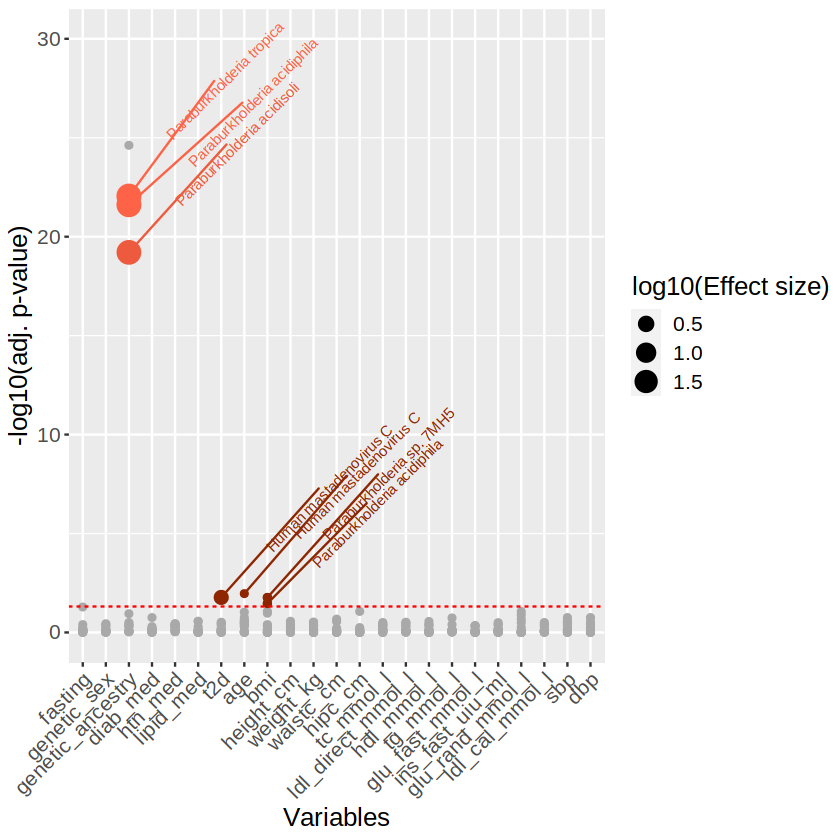

In [10]:
a <- 0.05

plot_df <- final %>%
    group_by(taxa, variable) %>%
    mutate(max_OR = max(odds_ratio)) %>%
    ungroup() %>%
    distinct(taxa, variable, .keep_all = T) %>%
    mutate(log_p_adj = -log(AOD_p.adj, base = 10),
           p.val_annot = ifelse(AOD_p.adj < a & param_p.adj < a, taxa, ""),
           OR_annot = ifelse(AOD_p.adj < a & param_p.adj < a, log_effect_size, NA),
           variable = factor(variable, levels = c(categorical_list, cont_list)),
           color_value = ifelse(AOD_p.adj < a & param_p.adj < a, log_p_adj, NA))

plot_df %>%
    ggplot(aes(x = variable, y = log_p_adj, color = color_value)) +
    geom_point() +
    geom_point(aes(size = OR_annot)) +
    geom_hline(yintercept = -log(a, base = 10), 
               lty = "dashed",
               color = "red") +
    scale_color_gradient(low = "orangered4", 
                         high = "tomato1", 
                         na.value = "darkgray", 
                         guide = "none") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          text = element_text(size = 15)) +
    geom_text_repel(aes(label = p.val_annot), angle = 45, hjust = 0, size = 3) +
    labs(x = "Variables", y = "-log10(adj. p-value)",
         size = "log10(Effect size)") +
    ylim(0, 30)

ggsave("results/phenotype_associations/manhattan_plot.glm.png", dpi = 600, width = 12)

Saving 6.67 x 6.67 in image



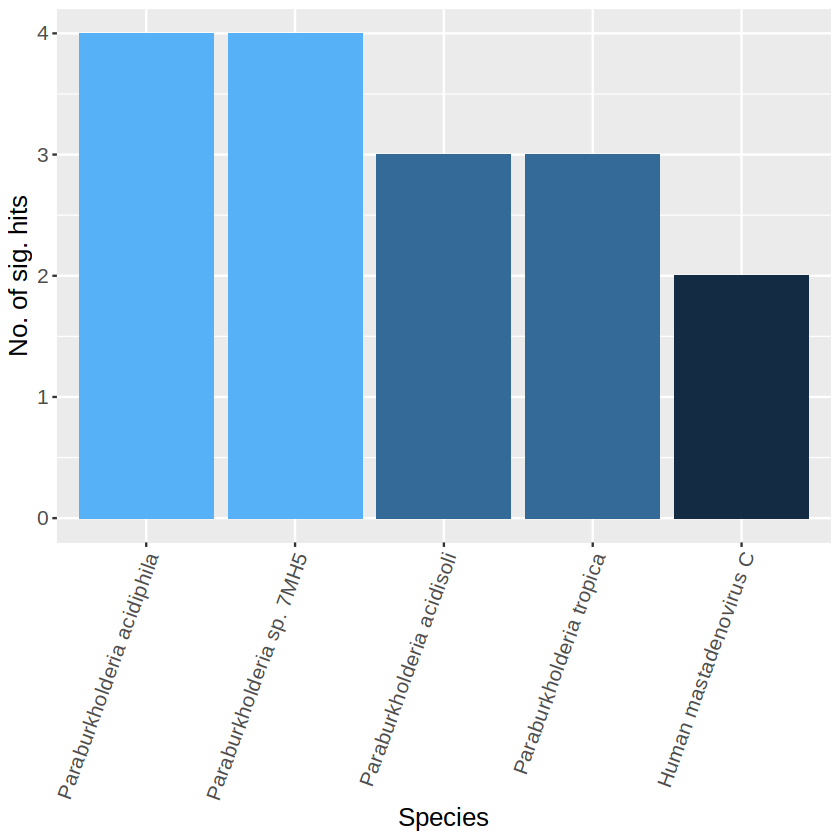

In [11]:
taxa_counts <- final %>%
    mutate(is_sig = ifelse(AOD_p.adj < a, T, F)) %>%
    filter(is_sig) %>%
    group_by(taxa) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

hit_plt <- taxa_counts %>%
    mutate(taxa = factor(taxa, unique(taxa_counts$taxa))) %>%
    ggplot(aes(x = taxa, y = n, fill = n)) +
    geom_bar(stat = "identity") +
    theme(legend.position = "none", 
          axis.text.x = element_text(angle = 70, hjust = 1),
          text = element_text(size = 15)) +
    labs(x = "Species", y = "No. of sig. hits")

hit_plt
ggsave("results/phenotype_associations/assoc_hit_count_barchart.png", dpi = 600)

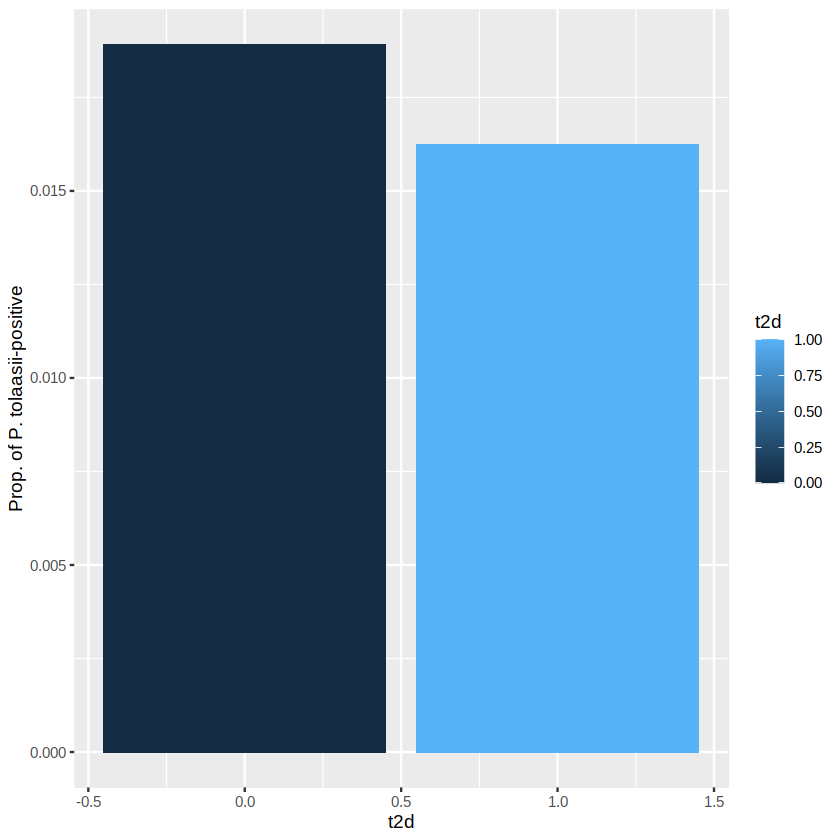

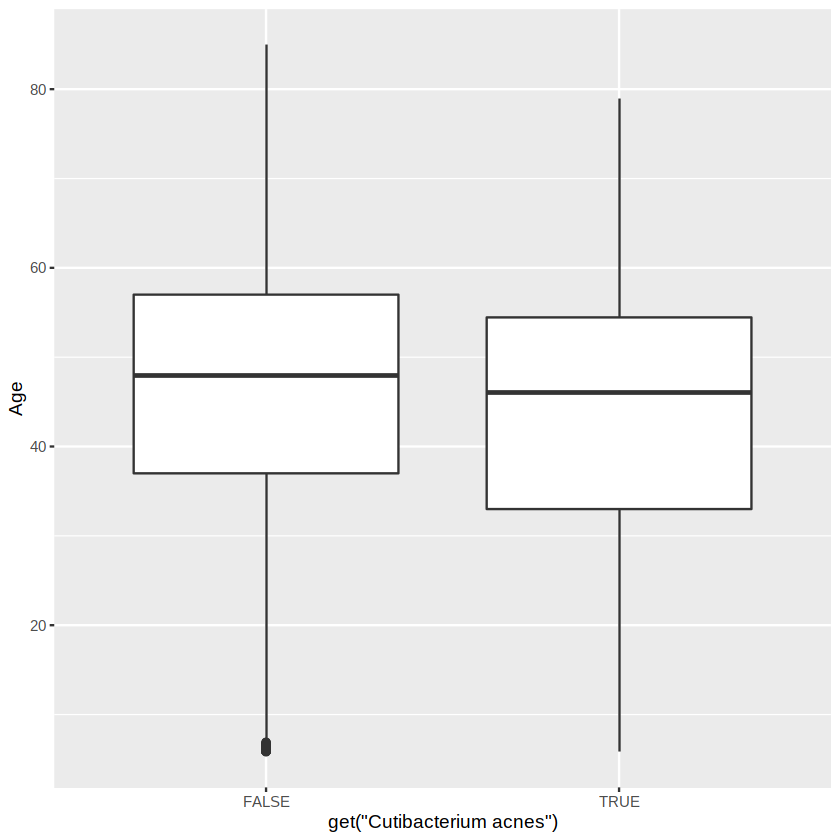

In [12]:
X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(t2d)) %>%
    group_by(t2d) %>%
    summarise(prop = sum(get("Human mastadenovirus C")) / n()) %>%
    ggplot(aes(x = t2d, y = prop, fill = t2d))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of P. tolaasii-positive")

X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(age)) %>%
    ggplot(aes(x = get("Cutibacterium acnes"), y = age))  +
        geom_boxplot() +
        labs(y = "Age")

In [13]:
X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(genetic_ancestry)) %>%
    group_by(genetic_ancestry) %>%
    summarise(prop = sum(get("Pseudomonas tolaasii")) / n()) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of P. tolaasii-positive")

X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(genetic_ancestry)) %>%
    group_by(genetic_ancestry) %>%
    summarise(prop = sum(get("Microbacterium sp. PM5")) / n()) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of Microbacterium-positive")

X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(genetic_ancestry)) %>%
    group_by(genetic_ancestry) %>%
    summarise(prop = sum(get("Paraburkholderia sp. 7MH5")) / n()) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of Microbacterium-positive")


ERROR: [1m[33mError[39m in [1m[1m[30m[47m`h()`[49m[39m:[22m
[33m![39m Problem with `summarise()` column `prop`.
[34mℹ[39m `prop = sum(get("Pseudomonas tolaasii"))/n()`.
[31m✖[39m object 'Pseudomonas tolaasii' not found
[34mℹ[39m The error occurred in group 1: genetic_ancestry = "C".
